In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from pytorch_tabnet.tab_model import TabNetClassifier
import numpy as np
from imblearn.over_sampling import SMOTE
import optuna

In [18]:
# Load datasets
red = pd.read_csv("../data/wine+quality/winequality-red.csv", sep=';')
white = pd.read_csv("../data/wine+quality/winequality-white.csv", sep=';')

# Add 'type' feature
red['type'] = 'red'
white['type'] = 'white'

# Combine datasets
df = pd.concat([red, white], ignore_index=True)

# One-hot encode 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Separate features and target
X = df.drop('quality', axis=1)
y = df['quality']

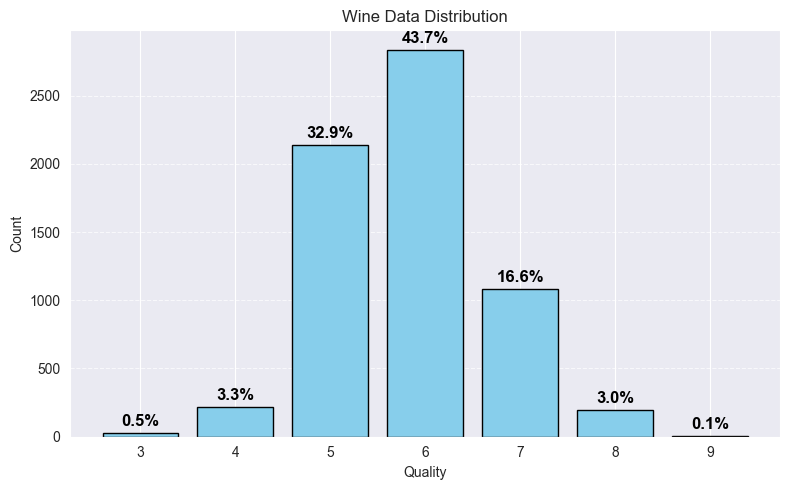

In [19]:
# Visualize distribution.

# Count and ratio
counts = y.value_counts().sort_index()
ratios = counts / counts.sum()

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')

# Add percentage labels on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    ratio = ratios.iloc[i]
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 30,
        f"{ratio:.1%}",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold',
        color='black'  # Force pure white
    )


# Titles and axes
plt.title("Wine Data Distribution")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.xticks(counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [20]:

# Load datasets
red = pd.read_csv("../data/wine+quality/winequality-red.csv", sep=';')
white = pd.read_csv("../data/wine+quality/winequality-white.csv", sep=';')

# Add 'type' feature
red['type'] = 'red'
white['type'] = 'white'

# Combine datasets
df = pd.concat([red, white], ignore_index=True)

# One-hot encode 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

le = LabelEncoder()
y_all = le.fit_transform(df['quality'])

# Separate features and target
X = df.drop('quality', axis=1)
y = df['quality']


# 1. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# 2. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Separate rare classes (e.g., <10 samples)
y_series = pd.Series(y_train).reset_index(drop=True)
X_df = pd.DataFrame(X_train_scaled).reset_index(drop=True)

class_counts = y_series.value_counts()
rare_classes = class_counts[class_counts < 1000].index.tolist()

# 4. Split training data: SMOTE-safe vs rare
mask = ~y_series.isin(rare_classes)
X_safe = X_df[mask].values
y_safe = y_series[mask].values

X_rare = X_df[~mask].values
y_rare = y_series[~mask].values

# 5. Apply SMOTE on SMOTE-safe subset only
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_safe, y_safe)

# 6. Combine all: original + resampled
X_train_final = np.vstack([X_train_scaled, X_smote])
y_train_final = np.hstack([y_train, y_smote])


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [21]:
# Initialize TabNet classifier
clf = TabNetClassifier()

# Train the model
clf.fit(
    X_train=X_train_final, y_train=y_train_final,
    eval_set=[(X_test_scaled, y_test)],
    eval_name=['test'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
    batch_size=256*2,
    virtual_batch_size=128*2,
    num_workers=0,
    drop_last=False
)

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.43517 | test_accuracy: 0.46538 |  0:00:00s
epoch 1  | loss: 1.04292 | test_accuracy: 0.50769 |  0:00:00s
epoch 2  | loss: 0.98452 | test_accuracy: 0.53077 |  0:00:00s
epoch 3  | loss: 0.97266 | test_accuracy: 0.51462 |  0:00:01s
epoch 4  | loss: 0.95135 | test_accuracy: 0.53077 |  0:00:01s
epoch 5  | loss: 0.94819 | test_accuracy: 0.52538 |  0:00:01s
epoch 6  | loss: 0.93681 | test_accuracy: 0.53308 |  0:00:02s
epoch 7  | loss: 0.92687 | test_accuracy: 0.52923 |  0:00:02s
epoch 8  | loss: 0.92044 | test_accuracy: 0.52692 |  0:00:02s
epoch 9  | loss: 0.91475 | test_accuracy: 0.53923 |  0:00:02s
epoch 10 | loss: 0.91327 | test_accuracy: 0.52615 |  0:00:03s
epoch 11 | loss: 0.91277 | test_accuracy: 0.53769 |  0:00:03s
epoch 12 | loss: 0.90813 | test_accuracy: 0.55077 |  0:00:03s
epoch 13 | loss: 0.91067 | test_accuracy: 0.53923 |  0:00:04s
epoch 14 | loss: 0.91701 | test_accuracy: 0.53077 |  0:00:04s
epoch 15 | loss: 0.90267 | test_accuracy: 0.53846 |  0:00:04s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [22]:
from sympy.printing.pytorch import torch
import optuna
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score
import torch
import numpy as np

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

np.random.seed(42)


X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_final, y_train_final,
    test_size=0.2, stratify=y_train_final, random_state=42
)

def objective(trial):
    params = {
        "n_d": trial.suggest_categorical("n_d", [8, 16, 32]),
        "n_a": trial.suggest_categorical("n_a", [8, 16, 32]),
        "n_steps": trial.suggest_int("n_steps", 3, 10),
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True),
        "optimizer_params": dict(lr=trial.suggest_float("lr", 1e-4, 1e-2, log=True)),
        "mask_type": trial.suggest_categorical("mask_type", ["entmax", "sparsemax"]),
        "batch_size": trial.suggest_categorical("batch_size", [512, 1024]),
        "virtual_batch_size": trial.suggest_categorical("virtual_batch_size", [128, 256]),
    }


    clf = TabNetClassifier(
        n_d=params["n_d"],
        n_a=params["n_a"],
        n_steps=params["n_steps"],
        gamma=params["gamma"],
        lambda_sparse=params["lambda_sparse"],
        optimizer_params=params["optimizer_params"],
        mask_type=params["mask_type"],
        verbose=1
    )

    clf.fit(
        X_train=X_train_final, y_train=y_train_final,
        eval_set=[(X_val, y_val)],
        num_workers=0,
        eval_name=["test"],
        eval_metric=["accuracy"],
        max_epochs=100,
        patience=10,
        batch_size=params["batch_size"],
        virtual_batch_size=params["virtual_batch_size"],
        drop_last=False
    )

    preds = clf.predict(X_val)
    acc = accuracy_score(y_val, preds)
    return acc


# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# Best results
print("Best trial:")
print(study.best_trial)


[I 2025-05-20 15:44:16,488] A new study created in memory with name: no-name-be0a94c2-6f27-4ae6-897d-7f7534b61208
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 6.41613 | test_accuracy: 0.03441 |  0:00:00s
epoch 1  | loss: 4.30095 | test_accuracy: 0.1397  |  0:00:01s
epoch 2  | loss: 3.1018  | test_accuracy: 0.33436 |  0:00:02s
epoch 3  | loss: 2.22736 | test_accuracy: 0.48536 |  0:00:03s
epoch 4  | loss: 1.8027  | test_accuracy: 0.51823 |  0:00:04s
epoch 5  | loss: 1.56233 | test_accuracy: 0.50385 |  0:00:05s
epoch 6  | loss: 1.38404 | test_accuracy: 0.51464 |  0:00:05s
epoch 7  | loss: 1.29547 | test_accuracy: 0.52645 |  0:00:06s
epoch 8  | loss: 1.27105 | test_accuracy: 0.52234 |  0:00:08s
epoch 9  | loss: 1.21104 | test_accuracy: 0.5244  |  0:00:09s
epoch 10 | loss: 1.19415 | test_accuracy: 0.53416 |  0:00:10s
epoch 11 | loss: 1.15461 | test_accuracy: 0.54854 |  0:00:11s
epoch 12 | loss: 1.14604 | test_accuracy: 0.52953 |  0:00:12s
epoch 13 | loss: 1.1248  | test_accuracy: 0.5434  |  0:00:13s
epoch 14 | loss: 1.09207 | test_accuracy: 0.55573 |  0:00:14s
epoch 15 | loss: 1.08169 | test_accuracy: 0.55573 |  0:00:16s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:45:19,910] Trial 0 finished with value: 0.613251155624037 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 9, 'gamma': 1.3429979017016884, 'lambda_sparse': 0.003182144273075528, 'lr': 0.003975430742925044, 'mask_type': 'sparsemax', 'batch_size': 1024, 'virtual_batch_size': 128}. Best is trial 0 with value: 0.613251155624037.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.1052  | test_accuracy: 0.42167 |  0:00:00s
epoch 1  | loss: 1.39028 | test_accuracy: 0.51618 |  0:00:01s
epoch 2  | loss: 1.22504 | test_accuracy: 0.51464 |  0:00:02s
epoch 3  | loss: 1.12147 | test_accuracy: 0.5511  |  0:00:03s
epoch 4  | loss: 1.08375 | test_accuracy: 0.55984 |  0:00:03s
epoch 5  | loss: 1.05008 | test_accuracy: 0.54854 |  0:00:04s
epoch 6  | loss: 1.04313 | test_accuracy: 0.55778 |  0:00:05s
epoch 7  | loss: 1.0373  | test_accuracy: 0.5773  |  0:00:05s
epoch 8  | loss: 1.00806 | test_accuracy: 0.55008 |  0:00:06s
epoch 9  | loss: 1.00719 | test_accuracy: 0.57524 |  0:00:07s
epoch 10 | loss: 0.98452 | test_accuracy: 0.54289 |  0:00:08s
epoch 11 | loss: 0.99153 | test_accuracy: 0.5773  |  0:00:09s
epoch 12 | loss: 0.96128 | test_accuracy: 0.60555 |  0:00:09s
epoch 13 | loss: 0.95446 | test_accuracy: 0.58603 |  0:00:10s
epoch 14 | loss: 0.94248 | test_accuracy: 0.58243 |  0:00:11s
epoch 15 | loss: 0.93558 | test_accuracy: 0.585   |  0:00:12s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:45:38,137] Trial 1 finished with value: 0.6055469953775039 and parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 7, 'gamma': 1.568276734932656, 'lambda_sparse': 7.59318141904412e-05, 'lr': 0.00927748477385235, 'mask_type': 'entmax', 'batch_size': 1024, 'virtual_batch_size': 256}. Best is trial 0 with value: 0.613251155624037.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.02842 | test_accuracy: 0.38932 |  0:00:01s
epoch 1  | loss: 1.6563  | test_accuracy: 0.44325 |  0:00:02s
epoch 2  | loss: 1.45365 | test_accuracy: 0.46944 |  0:00:03s
epoch 3  | loss: 1.34573 | test_accuracy: 0.47252 |  0:00:03s
epoch 4  | loss: 1.27511 | test_accuracy: 0.49872 |  0:00:04s
epoch 5  | loss: 1.23211 | test_accuracy: 0.51669 |  0:00:05s
epoch 6  | loss: 1.19262 | test_accuracy: 0.5131  |  0:00:06s
epoch 7  | loss: 1.15741 | test_accuracy: 0.52799 |  0:00:07s
epoch 8  | loss: 1.13778 | test_accuracy: 0.52748 |  0:00:08s
epoch 9  | loss: 1.11919 | test_accuracy: 0.52902 |  0:00:09s
epoch 10 | loss: 1.09047 | test_accuracy: 0.52131 |  0:00:10s
epoch 11 | loss: 1.07922 | test_accuracy: 0.54083 |  0:00:10s
epoch 12 | loss: 1.07395 | test_accuracy: 0.55419 |  0:00:11s
epoch 13 | loss: 1.06578 | test_accuracy: 0.53929 |  0:00:12s
epoch 14 | loss: 1.06069 | test_accuracy: 0.54597 |  0:00:13s
epoch 15 | loss: 1.05795 | test_accuracy: 0.55316 |  0:00:14s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:46:23,922] Trial 2 finished with value: 0.6040061633281972 and parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 7, 'gamma': 1.8607772487290903, 'lambda_sparse': 0.0025792299828894206, 'lr': 0.002192154705788445, 'mask_type': 'sparsemax', 'batch_size': 512, 'virtual_batch_size': 128}. Best is trial 0 with value: 0.613251155624037.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 7.25808 | test_accuracy: 0.01952 |  0:00:00s
epoch 1  | loss: 7.09081 | test_accuracy: 0.01952 |  0:00:01s
epoch 2  | loss: 6.99961 | test_accuracy: 0.01798 |  0:00:02s
epoch 3  | loss: 6.86561 | test_accuracy: 0.02054 |  0:00:02s
epoch 4  | loss: 6.75396 | test_accuracy: 0.02054 |  0:00:03s
epoch 5  | loss: 6.62566 | test_accuracy: 0.0226  |  0:00:04s
epoch 6  | loss: 6.54022 | test_accuracy: 0.02363 |  0:00:05s
epoch 7  | loss: 6.3799  | test_accuracy: 0.02517 |  0:00:05s
epoch 8  | loss: 6.29695 | test_accuracy: 0.02619 |  0:00:06s
epoch 9  | loss: 6.2361  | test_accuracy: 0.02414 |  0:00:07s
epoch 10 | loss: 6.07023 | test_accuracy: 0.02876 |  0:00:08s
epoch 11 | loss: 5.98608 | test_accuracy: 0.02979 |  0:00:09s
epoch 12 | loss: 5.93855 | test_accuracy: 0.0303  |  0:00:09s
epoch 13 | loss: 5.84523 | test_accuracy: 0.03236 |  0:00:10s
epoch 14 | loss: 5.79349 | test_accuracy: 0.03236 |  0:00:11s
epoch 15 | loss: 5.74214 | test_accuracy: 0.03749 |  0:00:11s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:47:37,077] Trial 3 finished with value: 0.3913713405238829 and parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 7, 'gamma': 1.8069531470309854, 'lambda_sparse': 0.004415262522089323, 'lr': 0.00020682207554267921, 'mask_type': 'sparsemax', 'batch_size': 1024, 'virtual_batch_size': 128}. Best is trial 0 with value: 0.613251155624037.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.57054 | test_accuracy: 0.18182 |  0:00:00s
epoch 1  | loss: 3.54874 | test_accuracy: 0.17565 |  0:00:01s
epoch 2  | loss: 3.48809 | test_accuracy: 0.18644 |  0:00:02s
epoch 3  | loss: 3.42989 | test_accuracy: 0.17668 |  0:00:03s
epoch 4  | loss: 3.45117 | test_accuracy: 0.17925 |  0:00:03s
epoch 5  | loss: 3.37065 | test_accuracy: 0.18593 |  0:00:04s
epoch 6  | loss: 3.34989 | test_accuracy: 0.18644 |  0:00:05s
epoch 7  | loss: 3.31013 | test_accuracy: 0.1926  |  0:00:06s
epoch 8  | loss: 3.29985 | test_accuracy: 0.1962  |  0:00:06s
epoch 9  | loss: 3.25704 | test_accuracy: 0.19979 |  0:00:07s
epoch 10 | loss: 3.20538 | test_accuracy: 0.20185 |  0:00:08s
epoch 11 | loss: 3.15413 | test_accuracy: 0.20339 |  0:00:09s
epoch 12 | loss: 3.14258 | test_accuracy: 0.20647 |  0:00:10s
epoch 13 | loss: 3.10514 | test_accuracy: 0.21726 |  0:00:10s
epoch 14 | loss: 3.07129 | test_accuracy: 0.21777 |  0:00:11s
epoch 15 | loss: 3.02763 | test_accuracy: 0.22239 |  0:00:12s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:48:47,766] Trial 4 finished with value: 0.46687211093990755 and parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 8, 'gamma': 1.273613665191232, 'lambda_sparse': 0.00409002309699419, 'lr': 0.00012516748074582954, 'mask_type': 'sparsemax', 'batch_size': 1024, 'virtual_batch_size': 256}. Best is trial 0 with value: 0.613251155624037.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.60911 | test_accuracy: 0.19055 |  0:00:00s
epoch 1  | loss: 3.52392 | test_accuracy: 0.19004 |  0:00:00s
epoch 2  | loss: 3.46058 | test_accuracy: 0.20955 |  0:00:01s
epoch 3  | loss: 3.39284 | test_accuracy: 0.21983 |  0:00:02s
epoch 4  | loss: 3.32767 | test_accuracy: 0.2265  |  0:00:02s
epoch 5  | loss: 3.28721 | test_accuracy: 0.22445 |  0:00:02s
epoch 6  | loss: 3.21613 | test_accuracy: 0.21983 |  0:00:03s
epoch 7  | loss: 3.13447 | test_accuracy: 0.22137 |  0:00:03s
epoch 8  | loss: 3.05155 | test_accuracy: 0.2301  |  0:00:04s
epoch 9  | loss: 3.0049  | test_accuracy: 0.23677 |  0:00:04s
epoch 10 | loss: 2.94751 | test_accuracy: 0.23729 |  0:00:05s
epoch 11 | loss: 2.86821 | test_accuracy: 0.24345 |  0:00:05s
epoch 12 | loss: 2.78009 | test_accuracy: 0.24807 |  0:00:06s
epoch 13 | loss: 2.74905 | test_accuracy: 0.25424 |  0:00:06s
epoch 14 | loss: 2.70195 | test_accuracy: 0.25989 |  0:00:07s
epoch 15 | loss: 2.64822 | test_accuracy: 0.25937 |  0:00:07s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:49:33,916] Trial 5 finished with value: 0.5649717514124294 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.2133520798758486, 'lambda_sparse': 2.0679273420140793e-05, 'lr': 0.0001317624758562132, 'mask_type': 'sparsemax', 'batch_size': 512, 'virtual_batch_size': 256}. Best is trial 0 with value: 0.613251155624037.


epoch 99 | loss: 1.09481 | test_accuracy: 0.56446 |  0:00:45s
Stop training because you reached max_epochs = 100 with best_epoch = 90 and best_test_accuracy = 0.56497


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.67489 | test_accuracy: 0.18439 |  0:00:00s
epoch 1  | loss: 3.5714  | test_accuracy: 0.19877 |  0:00:01s
epoch 2  | loss: 3.52163 | test_accuracy: 0.20236 |  0:00:01s
epoch 3  | loss: 3.44132 | test_accuracy: 0.19979 |  0:00:02s
epoch 4  | loss: 3.35354 | test_accuracy: 0.20699 |  0:00:02s
epoch 5  | loss: 3.32968 | test_accuracy: 0.20236 |  0:00:03s
epoch 6  | loss: 3.25676 | test_accuracy: 0.20236 |  0:00:04s
epoch 7  | loss: 3.22326 | test_accuracy: 0.21777 |  0:00:04s
epoch 8  | loss: 3.1307  | test_accuracy: 0.22445 |  0:00:05s
epoch 9  | loss: 3.06221 | test_accuracy: 0.2265  |  0:00:05s
epoch 10 | loss: 3.00155 | test_accuracy: 0.23523 |  0:00:06s
epoch 11 | loss: 2.91516 | test_accuracy: 0.23164 |  0:00:06s
epoch 12 | loss: 2.87454 | test_accuracy: 0.24551 |  0:00:07s
epoch 13 | loss: 2.81091 | test_accuracy: 0.24859 |  0:00:08s
epoch 14 | loss: 2.74421 | test_accuracy: 0.25372 |  0:00:08s
epoch 15 | loss: 2.68322 | test_accuracy: 0.25578 |  0:00:09s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:50:31,405] Trial 6 finished with value: 0.5747303543913713 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.7568183759651528, 'lambda_sparse': 0.0005392504161373644, 'lr': 0.00013673312566455287, 'mask_type': 'entmax', 'batch_size': 512, 'virtual_batch_size': 128}. Best is trial 0 with value: 0.613251155624037.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.24067 | test_accuracy: 0.10889 |  0:00:00s
epoch 1  | loss: 3.16238 | test_accuracy: 0.11659 |  0:00:01s
epoch 2  | loss: 3.0229  | test_accuracy: 0.13046 |  0:00:02s
epoch 3  | loss: 2.91916 | test_accuracy: 0.14381 |  0:00:02s
epoch 4  | loss: 2.79129 | test_accuracy: 0.16076 |  0:00:03s
epoch 5  | loss: 2.67404 | test_accuracy: 0.17103 |  0:00:04s
epoch 6  | loss: 2.60252 | test_accuracy: 0.18901 |  0:00:04s
epoch 7  | loss: 2.52984 | test_accuracy: 0.21572 |  0:00:05s
epoch 8  | loss: 2.44405 | test_accuracy: 0.23523 |  0:00:06s
epoch 9  | loss: 2.38843 | test_accuracy: 0.24705 |  0:00:07s
epoch 10 | loss: 2.31919 | test_accuracy: 0.26656 |  0:00:07s
epoch 11 | loss: 2.23359 | test_accuracy: 0.29635 |  0:00:08s
epoch 12 | loss: 2.14532 | test_accuracy: 0.31895 |  0:00:09s
epoch 13 | loss: 2.09717 | test_accuracy: 0.33847 |  0:00:10s
epoch 14 | loss: 2.0262  | test_accuracy: 0.35799 |  0:00:10s
epoch 15 | loss: 1.97609 | test_accuracy: 0.36775 |  0:00:11s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:51:46,318] Trial 7 finished with value: 0.5731895223420647 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 8, 'gamma': 1.338123644944191, 'lambda_sparse': 0.00019212196783902348, 'lr': 0.00015059393115342775, 'mask_type': 'entmax', 'batch_size': 512, 'virtual_batch_size': 256}. Best is trial 0 with value: 0.613251155624037.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.44917 | test_accuracy: 0.28043 |  0:00:00s
epoch 1  | loss: 3.46867 | test_accuracy: 0.26091 |  0:00:00s
epoch 2  | loss: 3.40771 | test_accuracy: 0.24294 |  0:00:01s
epoch 3  | loss: 3.38044 | test_accuracy: 0.23164 |  0:00:01s
epoch 4  | loss: 3.37563 | test_accuracy: 0.23729 |  0:00:02s
epoch 5  | loss: 3.34921 | test_accuracy: 0.26091 |  0:00:02s
epoch 6  | loss: 3.33524 | test_accuracy: 0.26246 |  0:00:03s
epoch 7  | loss: 3.2936  | test_accuracy: 0.25937 |  0:00:03s
epoch 8  | loss: 3.26123 | test_accuracy: 0.264   |  0:00:04s
epoch 9  | loss: 3.25405 | test_accuracy: 0.26759 |  0:00:04s


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:51:51,928] Trial 8 finished with value: 0.28043143297380585 and parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 8, 'gamma': 1.4920105863122788, 'lambda_sparse': 8.003364736320007e-05, 'lr': 0.00011568093402633078, 'mask_type': 'entmax', 'batch_size': 1024, 'virtual_batch_size': 256}. Best is trial 0 with value: 0.613251155624037.


epoch 10 | loss: 3.23471 | test_accuracy: 0.25475 |  0:00:05s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_test_accuracy = 0.28043


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.73223 | test_accuracy: 0.47612 |  0:00:00s
epoch 1  | loss: 1.23623 | test_accuracy: 0.53878 |  0:00:00s
epoch 2  | loss: 1.12009 | test_accuracy: 0.55521 |  0:00:01s
epoch 3  | loss: 1.06192 | test_accuracy: 0.57114 |  0:00:01s
epoch 4  | loss: 1.03412 | test_accuracy: 0.59014 |  0:00:02s
epoch 5  | loss: 1.01027 | test_accuracy: 0.58449 |  0:00:02s
epoch 6  | loss: 0.98749 | test_accuracy: 0.58243 |  0:00:03s
epoch 7  | loss: 0.97861 | test_accuracy: 0.57319 |  0:00:03s
epoch 8  | loss: 0.97389 | test_accuracy: 0.58141 |  0:00:04s
epoch 9  | loss: 0.96118 | test_accuracy: 0.58963 |  0:00:04s
epoch 10 | loss: 0.95808 | test_accuracy: 0.58295 |  0:00:05s
epoch 11 | loss: 0.95201 | test_accuracy: 0.59476 |  0:00:05s
epoch 12 | loss: 0.94346 | test_accuracy: 0.60092 |  0:00:06s
epoch 13 | loss: 0.93786 | test_accuracy: 0.61068 |  0:00:06s
epoch 14 | loss: 0.93396 | test_accuracy: 0.5999  |  0:00:06s
epoch 15 | loss: 0.93461 | test_accuracy: 0.60298 |  0:00:07s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:52:20,940] Trial 9 finished with value: 0.6512583461736005 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.873162299500314, 'lambda_sparse': 9.510616385030972e-05, 'lr': 0.005649894944444701, 'mask_type': 'sparsemax', 'batch_size': 1024, 'virtual_batch_size': 128}. Best is trial 9 with value: 0.6512583461736005.


epoch 61 | loss: 0.83145 | test_accuracy: 0.64355 |  0:00:28s

Early stopping occurred at epoch 61 with best_epoch = 51 and best_test_accuracy = 0.65126


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.38024 | test_accuracy: 0.06215 |  0:00:00s
epoch 1  | loss: 2.80729 | test_accuracy: 0.14432 |  0:00:00s
epoch 2  | loss: 2.38113 | test_accuracy: 0.24037 |  0:00:01s
epoch 3  | loss: 2.04277 | test_accuracy: 0.3508  |  0:00:01s
epoch 4  | loss: 1.7924  | test_accuracy: 0.42424 |  0:00:02s
epoch 5  | loss: 1.60655 | test_accuracy: 0.4905  |  0:00:02s
epoch 6  | loss: 1.45931 | test_accuracy: 0.51926 |  0:00:03s
epoch 7  | loss: 1.35206 | test_accuracy: 0.54186 |  0:00:03s
epoch 8  | loss: 1.28055 | test_accuracy: 0.54135 |  0:00:04s
epoch 9  | loss: 1.21994 | test_accuracy: 0.55984 |  0:00:04s
epoch 10 | loss: 1.17265 | test_accuracy: 0.56189 |  0:00:05s
epoch 11 | loss: 1.13911 | test_accuracy: 0.55008 |  0:00:05s
epoch 12 | loss: 1.11689 | test_accuracy: 0.55213 |  0:00:06s
epoch 13 | loss: 1.09306 | test_accuracy: 0.55265 |  0:00:06s
epoch 14 | loss: 1.07189 | test_accuracy: 0.56805 |  0:00:07s
epoch 15 | loss: 1.06829 | test_accuracy: 0.57576 |  0:00:07s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:52:56,762] Trial 10 finished with value: 0.6450950179763739 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.9733550992290787, 'lambda_sparse': 1.9233279923981242e-05, 'lr': 0.0008033338441937909, 'mask_type': 'sparsemax', 'batch_size': 1024, 'virtual_batch_size': 128}. Best is trial 9 with value: 0.6512583461736005.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.45096 | test_accuracy: 0.04931 |  0:00:00s
epoch 1  | loss: 2.99022 | test_accuracy: 0.09348 |  0:00:01s
epoch 2  | loss: 2.65034 | test_accuracy: 0.17206 |  0:00:01s
epoch 3  | loss: 2.36319 | test_accuracy: 0.24191 |  0:00:02s
epoch 4  | loss: 2.11711 | test_accuracy: 0.32152 |  0:00:02s
epoch 5  | loss: 1.90342 | test_accuracy: 0.39394 |  0:00:03s
epoch 6  | loss: 1.72272 | test_accuracy: 0.44633 |  0:00:04s
epoch 7  | loss: 1.58216 | test_accuracy: 0.48536 |  0:00:04s
epoch 8  | loss: 1.4878  | test_accuracy: 0.48947 |  0:00:05s
epoch 9  | loss: 1.40046 | test_accuracy: 0.50231 |  0:00:05s
epoch 10 | loss: 1.33824 | test_accuracy: 0.52491 |  0:00:06s
epoch 11 | loss: 1.28983 | test_accuracy: 0.53826 |  0:00:06s
epoch 12 | loss: 1.25061 | test_accuracy: 0.53826 |  0:00:07s
epoch 13 | loss: 1.21411 | test_accuracy: 0.5398  |  0:00:07s
epoch 14 | loss: 1.17712 | test_accuracy: 0.54186 |  0:00:08s
epoch 15 | loss: 1.15596 | test_accuracy: 0.54905 |  0:00:08s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:53:21,412] Trial 11 finished with value: 0.6065742167437083 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.9620741072597794, 'lambda_sparse': 1.928696847758741e-05, 'lr': 0.0005992572053811721, 'mask_type': 'sparsemax', 'batch_size': 1024, 'virtual_batch_size': 128}. Best is trial 9 with value: 0.6512583461736005.


epoch 47 | loss: 0.94248 | test_accuracy: 0.60452 |  0:00:24s

Early stopping occurred at epoch 47 with best_epoch = 37 and best_test_accuracy = 0.60657


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.41557 | test_accuracy: 0.06266 |  0:00:00s
epoch 1  | loss: 2.89099 | test_accuracy: 0.12789 |  0:00:01s
epoch 2  | loss: 2.47762 | test_accuracy: 0.21726 |  0:00:01s
epoch 3  | loss: 2.11897 | test_accuracy: 0.3282  |  0:00:02s
epoch 4  | loss: 1.84088 | test_accuracy: 0.42065 |  0:00:02s
epoch 5  | loss: 1.62368 | test_accuracy: 0.48485 |  0:00:03s
epoch 6  | loss: 1.46173 | test_accuracy: 0.5244  |  0:00:03s
epoch 7  | loss: 1.36194 | test_accuracy: 0.54186 |  0:00:04s
epoch 8  | loss: 1.28683 | test_accuracy: 0.53775 |  0:00:04s
epoch 9  | loss: 1.22478 | test_accuracy: 0.55419 |  0:00:05s
epoch 10 | loss: 1.17669 | test_accuracy: 0.566   |  0:00:05s
epoch 11 | loss: 1.14937 | test_accuracy: 0.57062 |  0:00:06s
epoch 12 | loss: 1.12065 | test_accuracy: 0.57319 |  0:00:06s
epoch 13 | loss: 1.11265 | test_accuracy: 0.57268 |  0:00:07s
epoch 14 | loss: 1.09186 | test_accuracy: 0.57114 |  0:00:07s
epoch 15 | loss: 1.07672 | test_accuracy: 0.57833 |  0:00:08s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:53:55,665] Trial 12 finished with value: 0.6358500256805342 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.6356916703878845, 'lambda_sparse': 1.008047396335102e-05, 'lr': 0.0007471987136054405, 'mask_type': 'sparsemax', 'batch_size': 1024, 'virtual_batch_size': 128}. Best is trial 9 with value: 0.6512583461736005.


epoch 66 | loss: 0.89158 | test_accuracy: 0.62404 |  0:00:34s

Early stopping occurred at epoch 66 with best_epoch = 56 and best_test_accuracy = 0.63585


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.5389  | test_accuracy: 0.36569 |  0:00:00s
epoch 1  | loss: 1.77875 | test_accuracy: 0.4905  |  0:00:01s
epoch 2  | loss: 1.40751 | test_accuracy: 0.52748 |  0:00:01s
epoch 3  | loss: 1.23738 | test_accuracy: 0.55881 |  0:00:02s
epoch 4  | loss: 1.13612 | test_accuracy: 0.5737  |  0:00:03s
epoch 5  | loss: 1.08921 | test_accuracy: 0.56959 |  0:00:03s
epoch 6  | loss: 1.05497 | test_accuracy: 0.58706 |  0:00:04s
epoch 7  | loss: 1.02365 | test_accuracy: 0.59476 |  0:00:05s
epoch 8  | loss: 1.01434 | test_accuracy: 0.58141 |  0:00:05s
epoch 9  | loss: 1.00358 | test_accuracy: 0.59887 |  0:00:06s
epoch 10 | loss: 0.98428 | test_accuracy: 0.59938 |  0:00:06s
epoch 11 | loss: 0.9786  | test_accuracy: 0.59784 |  0:00:07s
epoch 12 | loss: 0.95991 | test_accuracy: 0.6076  |  0:00:08s
epoch 13 | loss: 0.94875 | test_accuracy: 0.60247 |  0:00:08s
epoch 14 | loss: 0.9436  | test_accuracy: 0.6112  |  0:00:09s
epoch 15 | loss: 0.9406  | test_accuracy: 0.61325 |  0:00:10s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:54:55,299] Trial 13 finished with value: 0.6666666666666666 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 4, 'gamma': 1.000577900836613, 'lambda_sparse': 5.5022590042154394e-05, 'lr': 0.0017850922152588724, 'mask_type': 'sparsemax', 'batch_size': 1024, 'virtual_batch_size': 128}. Best is trial 13 with value: 0.6666666666666666.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.41271 | test_accuracy: 0.45763 |  0:00:00s
epoch 1  | loss: 1.53628 | test_accuracy: 0.51926 |  0:00:01s
epoch 2  | loss: 1.2854  | test_accuracy: 0.51104 |  0:00:02s
epoch 3  | loss: 1.16787 | test_accuracy: 0.52286 |  0:00:03s
epoch 4  | loss: 1.12447 | test_accuracy: 0.55162 |  0:00:04s
epoch 5  | loss: 1.08098 | test_accuracy: 0.57576 |  0:00:04s
epoch 6  | loss: 1.04532 | test_accuracy: 0.57833 |  0:00:05s
epoch 7  | loss: 1.02117 | test_accuracy: 0.57884 |  0:00:06s
epoch 8  | loss: 1.0015  | test_accuracy: 0.58089 |  0:00:07s
epoch 9  | loss: 0.9684  | test_accuracy: 0.5886  |  0:00:08s
epoch 10 | loss: 0.97098 | test_accuracy: 0.60092 |  0:00:09s
epoch 11 | loss: 0.9671  | test_accuracy: 0.61376 |  0:00:10s
epoch 12 | loss: 0.95773 | test_accuracy: 0.60144 |  0:00:10s
epoch 13 | loss: 0.95349 | test_accuracy: 0.60657 |  0:00:11s
epoch 14 | loss: 0.93991 | test_accuracy: 0.61171 |  0:00:12s
epoch 15 | loss: 0.93208 | test_accuracy: 0.59733 |  0:00:13s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:55:47,385] Trial 14 finished with value: 0.6522855675398048 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0133346559903844, 'lambda_sparse': 0.0006121875163466326, 'lr': 0.002422868968579807, 'mask_type': 'sparsemax', 'batch_size': 1024, 'virtual_batch_size': 128}. Best is trial 13 with value: 0.6666666666666666.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.61212 | test_accuracy: 0.36415 |  0:00:00s
epoch 1  | loss: 1.81682 | test_accuracy: 0.48998 |  0:00:01s
epoch 2  | loss: 1.42057 | test_accuracy: 0.5244  |  0:00:02s
epoch 3  | loss: 1.25266 | test_accuracy: 0.54391 |  0:00:02s
epoch 4  | loss: 1.20814 | test_accuracy: 0.5511  |  0:00:03s
epoch 5  | loss: 1.14706 | test_accuracy: 0.53775 |  0:00:04s
epoch 6  | loss: 1.11498 | test_accuracy: 0.566   |  0:00:05s
epoch 7  | loss: 1.09449 | test_accuracy: 0.57627 |  0:00:05s
epoch 8  | loss: 1.07186 | test_accuracy: 0.57165 |  0:00:06s
epoch 9  | loss: 1.0536  | test_accuracy: 0.58141 |  0:00:07s
epoch 10 | loss: 1.03467 | test_accuracy: 0.59014 |  0:00:08s
epoch 11 | loss: 1.02368 | test_accuracy: 0.59476 |  0:00:08s
epoch 12 | loss: 0.99969 | test_accuracy: 0.60092 |  0:00:09s
epoch 13 | loss: 0.98396 | test_accuracy: 0.61376 |  0:00:10s
epoch 14 | loss: 0.96355 | test_accuracy: 0.60298 |  0:00:11s
epoch 15 | loss: 0.9604  | test_accuracy: 0.61222 |  0:00:11s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:56:08,732] Trial 15 finished with value: 0.6266050333846944 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.0196968050631112, 'lambda_sparse': 0.0007641098708318258, 'lr': 0.001545626465748313, 'mask_type': 'sparsemax', 'batch_size': 1024, 'virtual_batch_size': 128}. Best is trial 13 with value: 0.6666666666666666.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.53642 | test_accuracy: 0.36672 |  0:00:00s
epoch 1  | loss: 1.76109 | test_accuracy: 0.49718 |  0:00:01s
epoch 2  | loss: 1.38747 | test_accuracy: 0.54545 |  0:00:01s
epoch 3  | loss: 1.23205 | test_accuracy: 0.54391 |  0:00:02s
epoch 4  | loss: 1.15708 | test_accuracy: 0.57062 |  0:00:03s
epoch 5  | loss: 1.12277 | test_accuracy: 0.57833 |  0:00:03s
epoch 6  | loss: 1.08253 | test_accuracy: 0.58552 |  0:00:04s
epoch 7  | loss: 1.05548 | test_accuracy: 0.59219 |  0:00:04s
epoch 8  | loss: 1.03519 | test_accuracy: 0.585   |  0:00:05s
epoch 9  | loss: 1.01246 | test_accuracy: 0.58295 |  0:00:06s
epoch 10 | loss: 0.99302 | test_accuracy: 0.59219 |  0:00:06s
epoch 11 | loss: 0.98395 | test_accuracy: 0.59322 |  0:00:07s
epoch 12 | loss: 0.96372 | test_accuracy: 0.60452 |  0:00:08s
epoch 13 | loss: 0.95695 | test_accuracy: 0.60298 |  0:00:08s
epoch 14 | loss: 0.9546  | test_accuracy: 0.60401 |  0:00:09s
epoch 15 | loss: 0.93375 | test_accuracy: 0.5999  |  0:00:09s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:56:33,299] Trial 16 finished with value: 0.6481766820749871 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 4, 'gamma': 1.000425057304706, 'lambda_sparse': 0.0009195328261470907, 'lr': 0.0019168013635256715, 'mask_type': 'sparsemax', 'batch_size': 1024, 'virtual_batch_size': 128}. Best is trial 13 with value: 0.6666666666666666.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.87145 | test_accuracy: 0.16281 |  0:00:00s
epoch 1  | loss: 4.52846 | test_accuracy: 0.18336 |  0:00:01s
epoch 2  | loss: 4.31675 | test_accuracy: 0.19312 |  0:00:02s
epoch 3  | loss: 4.05555 | test_accuracy: 0.20699 |  0:00:03s
epoch 4  | loss: 3.80727 | test_accuracy: 0.21623 |  0:00:03s
epoch 5  | loss: 3.58265 | test_accuracy: 0.24499 |  0:00:04s
epoch 6  | loss: 3.4073  | test_accuracy: 0.24653 |  0:00:05s
epoch 7  | loss: 3.18917 | test_accuracy: 0.26091 |  0:00:06s
epoch 8  | loss: 2.95419 | test_accuracy: 0.28865 |  0:00:07s
epoch 9  | loss: 2.77551 | test_accuracy: 0.31587 |  0:00:07s
epoch 10 | loss: 2.55039 | test_accuracy: 0.34155 |  0:00:08s
epoch 11 | loss: 2.40426 | test_accuracy: 0.36723 |  0:00:09s
epoch 12 | loss: 2.2646  | test_accuracy: 0.38315 |  0:00:10s
epoch 13 | loss: 2.12247 | test_accuracy: 0.40164 |  0:00:10s
epoch 14 | loss: 2.01978 | test_accuracy: 0.40421 |  0:00:11s
epoch 15 | loss: 1.95399 | test_accuracy: 0.42886 |  0:00:12s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:57:29,574] Trial 17 finished with value: 0.5747303543913713 and parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 6, 'gamma': 1.1089359807078438, 'lambda_sparse': 0.00026575048016036013, 'lr': 0.00037815477654966253, 'mask_type': 'sparsemax', 'batch_size': 1024, 'virtual_batch_size': 128}. Best is trial 13 with value: 0.6666666666666666.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.86968 | test_accuracy: 0.56754 |  0:00:00s
epoch 1  | loss: 1.16378 | test_accuracy: 0.58808 |  0:00:01s
epoch 2  | loss: 1.05134 | test_accuracy: 0.60144 |  0:00:02s
epoch 3  | loss: 0.98194 | test_accuracy: 0.6112  |  0:00:02s
epoch 4  | loss: 0.96133 | test_accuracy: 0.61171 |  0:00:03s
epoch 5  | loss: 0.94409 | test_accuracy: 0.61839 |  0:00:04s
epoch 6  | loss: 0.92554 | test_accuracy: 0.60555 |  0:00:04s
epoch 7  | loss: 0.91248 | test_accuracy: 0.60863 |  0:00:05s
epoch 8  | loss: 0.8905  | test_accuracy: 0.62301 |  0:00:06s
epoch 9  | loss: 0.88582 | test_accuracy: 0.63071 |  0:00:06s
epoch 10 | loss: 0.87308 | test_accuracy: 0.61993 |  0:00:07s
epoch 11 | loss: 0.86082 | test_accuracy: 0.62917 |  0:00:08s
epoch 12 | loss: 0.85468 | test_accuracy: 0.6379  |  0:00:08s
epoch 13 | loss: 0.85059 | test_accuracy: 0.63277 |  0:00:09s
epoch 14 | loss: 0.83974 | test_accuracy: 0.63585 |  0:00:09s
epoch 15 | loss: 0.83892 | test_accuracy: 0.62352 |  0:00:10s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:58:04,163] Trial 18 finished with value: 0.6866974833076528 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 4, 'gamma': 1.1501946000609145, 'lambda_sparse': 0.0015522355263382782, 'lr': 0.0034457975361170466, 'mask_type': 'entmax', 'batch_size': 512, 'virtual_batch_size': 128}. Best is trial 18 with value: 0.6866974833076528.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.81752 | test_accuracy: 0.54802 |  0:00:00s
epoch 1  | loss: 1.15888 | test_accuracy: 0.56857 |  0:00:01s
epoch 2  | loss: 1.0497  | test_accuracy: 0.60709 |  0:00:01s
epoch 3  | loss: 0.99973 | test_accuracy: 0.60555 |  0:00:02s
epoch 4  | loss: 0.95412 | test_accuracy: 0.62096 |  0:00:03s
epoch 5  | loss: 0.93443 | test_accuracy: 0.6225  |  0:00:03s
epoch 6  | loss: 0.91846 | test_accuracy: 0.62969 |  0:00:04s
epoch 7  | loss: 0.90317 | test_accuracy: 0.62352 |  0:00:05s
epoch 8  | loss: 0.88948 | test_accuracy: 0.62969 |  0:00:05s
epoch 9  | loss: 0.88629 | test_accuracy: 0.62866 |  0:00:06s
epoch 10 | loss: 0.88492 | test_accuracy: 0.63431 |  0:00:07s
epoch 11 | loss: 0.8685  | test_accuracy: 0.63739 |  0:00:07s
epoch 12 | loss: 0.85934 | test_accuracy: 0.64458 |  0:00:08s
epoch 13 | loss: 0.86039 | test_accuracy: 0.64458 |  0:00:09s
epoch 14 | loss: 0.86028 | test_accuracy: 0.64355 |  0:00:09s
epoch 15 | loss: 0.85088 | test_accuracy: 0.6379  |  0:00:10s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:59:09,698] Trial 19 finished with value: 0.7385721623009759 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 4, 'gamma': 1.213287225900646, 'lambda_sparse': 0.008788520337902688, 'lr': 0.0036503942104555327, 'mask_type': 'entmax', 'batch_size': 512, 'virtual_batch_size': 128}. Best is trial 19 with value: 0.7385721623009759.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.25131 | test_accuracy: 0.51977 |  0:00:01s
epoch 1  | loss: 1.5322  | test_accuracy: 0.53416 |  0:00:02s
epoch 2  | loss: 1.35259 | test_accuracy: 0.57473 |  0:00:03s
epoch 3  | loss: 1.26968 | test_accuracy: 0.58963 |  0:00:05s
epoch 4  | loss: 1.1791  | test_accuracy: 0.56857 |  0:00:06s
epoch 5  | loss: 1.1312  | test_accuracy: 0.57576 |  0:00:07s
epoch 6  | loss: 1.10374 | test_accuracy: 0.5773  |  0:00:09s
epoch 7  | loss: 1.06674 | test_accuracy: 0.58141 |  0:00:10s
epoch 8  | loss: 1.0498  | test_accuracy: 0.59373 |  0:00:11s
epoch 9  | loss: 1.06663 | test_accuracy: 0.57935 |  0:00:13s
epoch 10 | loss: 1.03405 | test_accuracy: 0.57987 |  0:00:14s
epoch 11 | loss: 1.02004 | test_accuracy: 0.59271 |  0:00:15s
epoch 12 | loss: 1.01407 | test_accuracy: 0.60606 |  0:00:16s
epoch 13 | loss: 0.99237 | test_accuracy: 0.59425 |  0:00:18s
epoch 14 | loss: 0.98948 | test_accuracy: 0.59784 |  0:00:19s
epoch 15 | loss: 0.97714 | test_accuracy: 0.61582 |  0:00:20s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 15:59:56,893] Trial 20 finished with value: 0.6219825372367745 and parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 10, 'gamma': 1.1759795168918716, 'lambda_sparse': 0.008211563454521783, 'lr': 0.004158177136688408, 'mask_type': 'entmax', 'batch_size': 512, 'virtual_batch_size': 128}. Best is trial 19 with value: 0.7385721623009759.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.84151 | test_accuracy: 0.54135 |  0:00:00s
epoch 1  | loss: 1.15103 | test_accuracy: 0.57165 |  0:00:01s
epoch 2  | loss: 1.04147 | test_accuracy: 0.57216 |  0:00:01s
epoch 3  | loss: 0.98744 | test_accuracy: 0.59887 |  0:00:02s
epoch 4  | loss: 0.94866 | test_accuracy: 0.59887 |  0:00:03s
epoch 5  | loss: 0.9356  | test_accuracy: 0.61582 |  0:00:03s
epoch 6  | loss: 0.92376 | test_accuracy: 0.61325 |  0:00:04s
epoch 7  | loss: 0.90862 | test_accuracy: 0.62044 |  0:00:05s
epoch 8  | loss: 0.89429 | test_accuracy: 0.61376 |  0:00:06s
epoch 9  | loss: 0.87937 | test_accuracy: 0.62506 |  0:00:06s
epoch 10 | loss: 0.8767  | test_accuracy: 0.64099 |  0:00:07s
epoch 11 | loss: 0.87573 | test_accuracy: 0.63071 |  0:00:07s
epoch 12 | loss: 0.86077 | test_accuracy: 0.64047 |  0:00:08s
epoch 13 | loss: 0.85544 | test_accuracy: 0.62866 |  0:00:09s
epoch 14 | loss: 0.84974 | test_accuracy: 0.63482 |  0:00:10s
epoch 15 | loss: 0.83824 | test_accuracy: 0.63431 |  0:00:10s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 16:00:26,730] Trial 21 finished with value: 0.6825885978428351 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 4, 'gamma': 1.128727156894212, 'lambda_sparse': 0.00956110524986577, 'lr': 0.0034408457733325418, 'mask_type': 'entmax', 'batch_size': 512, 'virtual_batch_size': 128}. Best is trial 19 with value: 0.7385721623009759.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.5267  | test_accuracy: 0.52491 |  0:00:00s
epoch 1  | loss: 1.05432 | test_accuracy: 0.56035 |  0:00:01s
epoch 2  | loss: 0.9938  | test_accuracy: 0.59425 |  0:00:02s
epoch 3  | loss: 0.94639 | test_accuracy: 0.60401 |  0:00:02s
epoch 4  | loss: 0.91928 | test_accuracy: 0.6225  |  0:00:03s
epoch 5  | loss: 0.90586 | test_accuracy: 0.62558 |  0:00:04s
epoch 6  | loss: 0.89381 | test_accuracy: 0.62404 |  0:00:04s
epoch 7  | loss: 0.88934 | test_accuracy: 0.62352 |  0:00:05s
epoch 8  | loss: 0.87504 | test_accuracy: 0.62455 |  0:00:06s
epoch 9  | loss: 0.85803 | test_accuracy: 0.6189  |  0:00:06s
epoch 10 | loss: 0.86355 | test_accuracy: 0.63123 |  0:00:07s
epoch 11 | loss: 0.8448  | test_accuracy: 0.62404 |  0:00:08s
epoch 12 | loss: 0.83913 | test_accuracy: 0.64099 |  0:00:08s
epoch 13 | loss: 0.83474 | test_accuracy: 0.64201 |  0:00:09s
epoch 14 | loss: 0.82404 | test_accuracy: 0.63123 |  0:00:10s
epoch 15 | loss: 0.83328 | test_accuracy: 0.63174 |  0:00:10s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 16:01:06,058] Trial 22 finished with value: 0.6933744221879815 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 4, 'gamma': 1.4146967797657481, 'lambda_sparse': 0.0018709337704911843, 'lr': 0.008596852682094574, 'mask_type': 'entmax', 'batch_size': 512, 'virtual_batch_size': 128}. Best is trial 19 with value: 0.7385721623009759.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.54768 | test_accuracy: 0.55932 |  0:00:00s
epoch 1  | loss: 1.05302 | test_accuracy: 0.57422 |  0:00:01s
epoch 2  | loss: 0.98155 | test_accuracy: 0.58808 |  0:00:02s
epoch 3  | loss: 0.94856 | test_accuracy: 0.60041 |  0:00:02s
epoch 4  | loss: 0.91376 | test_accuracy: 0.62558 |  0:00:03s
epoch 5  | loss: 0.90496 | test_accuracy: 0.62096 |  0:00:04s
epoch 6  | loss: 0.90331 | test_accuracy: 0.62301 |  0:00:04s
epoch 7  | loss: 0.89071 | test_accuracy: 0.61479 |  0:00:05s
epoch 8  | loss: 0.88063 | test_accuracy: 0.63945 |  0:00:06s
epoch 9  | loss: 0.87399 | test_accuracy: 0.6379  |  0:00:06s
epoch 10 | loss: 0.86675 | test_accuracy: 0.63636 |  0:00:07s
epoch 11 | loss: 0.86371 | test_accuracy: 0.63277 |  0:00:08s
epoch 12 | loss: 0.84978 | test_accuracy: 0.63688 |  0:00:08s
epoch 13 | loss: 0.85292 | test_accuracy: 0.63893 |  0:00:09s
epoch 14 | loss: 0.84358 | test_accuracy: 0.63893 |  0:00:10s
epoch 15 | loss: 0.85213 | test_accuracy: 0.63225 |  0:00:11s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 16:02:13,234] Trial 23 finished with value: 0.7539804827940421 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 4, 'gamma': 1.3542801903123354, 'lambda_sparse': 0.0015067427179960662, 'lr': 0.007483834315662805, 'mask_type': 'entmax', 'batch_size': 512, 'virtual_batch_size': 128}. Best is trial 23 with value: 0.7539804827940421.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.81578 | test_accuracy: 0.51977 |  0:00:00s
epoch 1  | loss: 1.12245 | test_accuracy: 0.56959 |  0:00:01s
epoch 2  | loss: 1.02623 | test_accuracy: 0.56703 |  0:00:02s
epoch 3  | loss: 0.99584 | test_accuracy: 0.59425 |  0:00:03s
epoch 4  | loss: 0.96322 | test_accuracy: 0.59938 |  0:00:04s
epoch 5  | loss: 0.94695 | test_accuracy: 0.59887 |  0:00:05s
epoch 6  | loss: 0.94103 | test_accuracy: 0.61222 |  0:00:06s
epoch 7  | loss: 0.92854 | test_accuracy: 0.61325 |  0:00:07s
epoch 8  | loss: 0.92421 | test_accuracy: 0.62096 |  0:00:08s
epoch 9  | loss: 0.90469 | test_accuracy: 0.61993 |  0:00:09s
epoch 10 | loss: 0.9018  | test_accuracy: 0.61736 |  0:00:10s
epoch 11 | loss: 0.89683 | test_accuracy: 0.6112  |  0:00:11s
epoch 12 | loss: 0.88976 | test_accuracy: 0.61479 |  0:00:12s
epoch 13 | loss: 0.88491 | test_accuracy: 0.61171 |  0:00:12s
epoch 14 | loss: 0.89244 | test_accuracy: 0.60709 |  0:00:13s
epoch 15 | loss: 0.8913  | test_accuracy: 0.60657 |  0:00:14s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 16:02:49,748] Trial 24 finished with value: 0.6332819722650231 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 6, 'gamma': 1.4296106389025924, 'lambda_sparse': 0.0016747163891916487, 'lr': 0.009366163726644774, 'mask_type': 'entmax', 'batch_size': 512, 'virtual_batch_size': 128}. Best is trial 23 with value: 0.7539804827940421.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.47768 | test_accuracy: 0.45403 |  0:00:00s
epoch 1  | loss: 1.31188 | test_accuracy: 0.57319 |  0:00:01s
epoch 2  | loss: 1.09756 | test_accuracy: 0.59733 |  0:00:01s
epoch 3  | loss: 1.03235 | test_accuracy: 0.5963  |  0:00:02s
epoch 4  | loss: 1.0008  | test_accuracy: 0.59322 |  0:00:03s
epoch 5  | loss: 0.97457 | test_accuracy: 0.60247 |  0:00:03s
epoch 6  | loss: 0.95691 | test_accuracy: 0.6112  |  0:00:04s
epoch 7  | loss: 0.94315 | test_accuracy: 0.61531 |  0:00:04s
epoch 8  | loss: 0.92172 | test_accuracy: 0.62301 |  0:00:05s
epoch 9  | loss: 0.91522 | test_accuracy: 0.6189  |  0:00:06s
epoch 10 | loss: 0.91122 | test_accuracy: 0.62352 |  0:00:06s
epoch 11 | loss: 0.89478 | test_accuracy: 0.62558 |  0:00:07s
epoch 12 | loss: 0.89631 | test_accuracy: 0.62301 |  0:00:07s
epoch 13 | loss: 0.89097 | test_accuracy: 0.62609 |  0:00:08s
epoch 14 | loss: 0.88862 | test_accuracy: 0.62044 |  0:00:09s
epoch 15 | loss: 0.88514 | test_accuracy: 0.62661 |  0:00:10s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 16:03:24,578] Trial 25 finished with value: 0.6702619414483821 and parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 4, 'gamma': 1.3235725133874385, 'lambda_sparse': 0.005514046454134327, 'lr': 0.006192025877081822, 'mask_type': 'entmax', 'batch_size': 512, 'virtual_batch_size': 128}. Best is trial 23 with value: 0.7539804827940421.


epoch 57 | loss: 0.75057 | test_accuracy: 0.66975 |  0:00:34s

Early stopping occurred at epoch 57 with best_epoch = 47 and best_test_accuracy = 0.67026


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.94725 | test_accuracy: 0.53672 |  0:00:00s
epoch 1  | loss: 1.13378 | test_accuracy: 0.55419 |  0:00:01s
epoch 2  | loss: 1.03017 | test_accuracy: 0.57216 |  0:00:02s
epoch 3  | loss: 0.98789 | test_accuracy: 0.585   |  0:00:03s
epoch 4  | loss: 0.95425 | test_accuracy: 0.61325 |  0:00:04s
epoch 5  | loss: 0.94486 | test_accuracy: 0.58808 |  0:00:05s
epoch 6  | loss: 0.93384 | test_accuracy: 0.61171 |  0:00:06s
epoch 7  | loss: 0.91418 | test_accuracy: 0.60401 |  0:00:06s
epoch 8  | loss: 0.89498 | test_accuracy: 0.61428 |  0:00:07s
epoch 9  | loss: 0.91239 | test_accuracy: 0.59887 |  0:00:08s
epoch 10 | loss: 0.88987 | test_accuracy: 0.60914 |  0:00:09s
epoch 11 | loss: 0.87981 | test_accuracy: 0.62506 |  0:00:10s
epoch 12 | loss: 0.87434 | test_accuracy: 0.61068 |  0:00:10s
epoch 13 | loss: 0.87776 | test_accuracy: 0.62609 |  0:00:11s
epoch 14 | loss: 0.87519 | test_accuracy: 0.61171 |  0:00:12s
epoch 15 | loss: 0.87283 | test_accuracy: 0.60298 |  0:00:13s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 16:03:50,998] Trial 26 finished with value: 0.6384180790960452 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 6, 'gamma': 1.433668941082768, 'lambda_sparse': 0.0017336709735101385, 'lr': 0.006960045372167099, 'mask_type': 'entmax', 'batch_size': 512, 'virtual_batch_size': 256}. Best is trial 23 with value: 0.7539804827940421.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.639   | test_accuracy: 0.50539 |  0:00:01s
epoch 1  | loss: 1.1069  | test_accuracy: 0.57473 |  0:00:02s
epoch 2  | loss: 1.02306 | test_accuracy: 0.59527 |  0:00:02s
epoch 3  | loss: 0.98393 | test_accuracy: 0.60195 |  0:00:03s
epoch 4  | loss: 0.94995 | test_accuracy: 0.60812 |  0:00:04s
epoch 5  | loss: 0.91992 | test_accuracy: 0.6189  |  0:00:06s
epoch 6  | loss: 0.90763 | test_accuracy: 0.63636 |  0:00:07s
epoch 7  | loss: 0.89154 | test_accuracy: 0.6189  |  0:00:07s
epoch 8  | loss: 0.89258 | test_accuracy: 0.62506 |  0:00:08s
epoch 9  | loss: 0.87997 | test_accuracy: 0.62404 |  0:00:09s
epoch 10 | loss: 0.87141 | test_accuracy: 0.62301 |  0:00:10s
epoch 11 | loss: 0.85566 | test_accuracy: 0.63636 |  0:00:11s
epoch 12 | loss: 0.86121 | test_accuracy: 0.62404 |  0:00:12s
epoch 13 | loss: 0.86247 | test_accuracy: 0.62096 |  0:00:12s
epoch 14 | loss: 0.84762 | test_accuracy: 0.62506 |  0:00:13s
epoch 15 | loss: 0.85203 | test_accuracy: 0.62558 |  0:00:14s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 16:04:06,604] Trial 27 finished with value: 0.6363636363636364 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.2579436289088035, 'lambda_sparse': 0.0012229821919809833, 'lr': 0.005258165066571801, 'mask_type': 'entmax', 'batch_size': 512, 'virtual_batch_size': 128}. Best is trial 23 with value: 0.7539804827940421.
/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.88644 | test_accuracy: 0.50693 |  0:00:00s
epoch 1  | loss: 1.0681  | test_accuracy: 0.58449 |  0:00:01s
epoch 2  | loss: 0.97838 | test_accuracy: 0.58757 |  0:00:01s
epoch 3  | loss: 0.95143 | test_accuracy: 0.60709 |  0:00:02s
epoch 4  | loss: 0.9314  | test_accuracy: 0.61582 |  0:00:03s
epoch 5  | loss: 0.91316 | test_accuracy: 0.62558 |  0:00:03s
epoch 6  | loss: 0.89695 | test_accuracy: 0.61274 |  0:00:04s
epoch 7  | loss: 0.88854 | test_accuracy: 0.62506 |  0:00:04s
epoch 8  | loss: 0.8744  | test_accuracy: 0.64612 |  0:00:05s
epoch 9  | loss: 0.86    | test_accuracy: 0.62866 |  0:00:05s
epoch 10 | loss: 0.8544  | test_accuracy: 0.6415  |  0:00:06s
epoch 11 | loss: 0.84645 | test_accuracy: 0.6379  |  0:00:07s
epoch 12 | loss: 0.84851 | test_accuracy: 0.62455 |  0:00:07s
epoch 13 | loss: 0.83861 | test_accuracy: 0.61993 |  0:00:08s
epoch 14 | loss: 0.83381 | test_accuracy: 0.64972 |  0:00:08s
epoch 15 | loss: 0.82679 | test_accuracy: 0.63123 |  0:00:09s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 16:04:34,268] Trial 28 finished with value: 0.6733436055469953 and parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 4, 'gamma': 1.4286732245726588, 'lambda_sparse': 0.00036912680625090415, 'lr': 0.008029856906237332, 'mask_type': 'entmax', 'batch_size': 512, 'virtual_batch_size': 128}. Best is trial 23 with value: 0.7539804827940421.


epoch 45 | loss: 0.71608 | test_accuracy: 0.66153 |  0:00:27s

Early stopping occurred at epoch 45 with best_epoch = 35 and best_test_accuracy = 0.67334


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.53388 | test_accuracy: 0.12275 |  0:00:00s
epoch 1  | loss: 2.06015 | test_accuracy: 0.33693 |  0:00:00s
epoch 2  | loss: 1.7506  | test_accuracy: 0.48947 |  0:00:01s
epoch 3  | loss: 1.53837 | test_accuracy: 0.54083 |  0:00:01s
epoch 4  | loss: 1.39242 | test_accuracy: 0.55829 |  0:00:02s
epoch 5  | loss: 1.2856  | test_accuracy: 0.57114 |  0:00:02s
epoch 6  | loss: 1.19631 | test_accuracy: 0.57935 |  0:00:02s
epoch 7  | loss: 1.13811 | test_accuracy: 0.5886  |  0:00:03s
epoch 8  | loss: 1.0872  | test_accuracy: 0.59682 |  0:00:03s
epoch 9  | loss: 1.04815 | test_accuracy: 0.60657 |  0:00:04s
epoch 10 | loss: 1.02662 | test_accuracy: 0.61068 |  0:00:04s
epoch 11 | loss: 1.00125 | test_accuracy: 0.6189  |  0:00:05s
epoch 12 | loss: 0.98478 | test_accuracy: 0.61787 |  0:00:05s
epoch 13 | loss: 0.97104 | test_accuracy: 0.62352 |  0:00:06s
epoch 14 | loss: 0.96149 | test_accuracy: 0.61993 |  0:00:06s
epoch 15 | loss: 0.95398 | test_accuracy: 0.61839 |  0:00:07s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-05-20 16:04:45,149] Trial 29 finished with value: 0.6235233692860811 and parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.6071829909582283, 'lambda_sparse': 0.0027253411149805147, 'lr': 0.0012095818772022032, 'mask_type': 'entmax', 'batch_size': 512, 'virtual_batch_size': 128}. Best is trial 23 with value: 0.7539804827940421.


epoch 23 | loss: 0.90132 | test_accuracy: 0.61736 |  0:00:10s

Early stopping occurred at epoch 23 with best_epoch = 13 and best_test_accuracy = 0.62352
Best trial:
FrozenTrial(number=23, state=TrialState.COMPLETE, values=[0.7539804827940421], datetime_start=datetime.datetime(2025, 5, 20, 16, 1, 6, 58713), datetime_complete=datetime.datetime(2025, 5, 20, 16, 2, 13, 234558), params={'n_d': 32, 'n_a': 32, 'n_steps': 4, 'gamma': 1.3542801903123354, 'lambda_sparse': 0.0015067427179960662, 'lr': 0.007483834315662805, 'mask_type': 'entmax', 'batch_size': 512, 'virtual_batch_size': 128}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_d': CategoricalDistribution(choices=(8, 16, 32)), 'n_a': CategoricalDistribution(choices=(8, 16, 32)), 'n_steps': IntDistribution(high=10, log=False, low=3, step=1), 'gamma': FloatDistribution(high=2.0, log=False, low=1.0, step=None), 'lambda_sparse': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'lr': FloatDistribution(

In [40]:
import numpy as np


best_params = study.best_trial.params
best_model = TabNetClassifier(
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    lambda_sparse=best_params["lambda_sparse"],
    optimizer_params={"lr": best_params["lr"]},
    mask_type=best_params["mask_type"],
    verbose=1
)

best_model.fit(
    X_train=X_train_final, y_train=y_train_final,
    eval_set=[(X_test_scaled, y_test)],
    eval_name=["test"],
    eval_metric=["accuracy"],
    max_epochs=200,
    patience=30,
    batch_size=best_params["batch_size"],
    virtual_batch_size=best_params["virtual_batch_size"],
    num_workers=0,
    drop_last=False
)

test_preds = best_model.predict(X_test_scaled)
test_acc = accuracy_score(y_test, test_preds)
print(f"Test accuracy: {test_acc:.4f}")


/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.54768 | test_accuracy: 0.48462 |  0:00:00s
epoch 1  | loss: 1.05302 | test_accuracy: 0.51154 |  0:00:01s
epoch 2  | loss: 0.98155 | test_accuracy: 0.52692 |  0:00:02s
epoch 3  | loss: 0.94856 | test_accuracy: 0.53077 |  0:00:02s
epoch 4  | loss: 0.91376 | test_accuracy: 0.54077 |  0:00:03s
epoch 5  | loss: 0.90496 | test_accuracy: 0.55385 |  0:00:04s
epoch 6  | loss: 0.90331 | test_accuracy: 0.55385 |  0:00:04s
epoch 7  | loss: 0.89071 | test_accuracy: 0.54692 |  0:00:05s
epoch 8  | loss: 0.88063 | test_accuracy: 0.55692 |  0:00:06s
epoch 9  | loss: 0.87399 | test_accuracy: 0.55    |  0:00:06s
epoch 10 | loss: 0.86675 | test_accuracy: 0.54923 |  0:00:07s
epoch 11 | loss: 0.86371 | test_accuracy: 0.55692 |  0:00:07s
epoch 12 | loss: 0.84978 | test_accuracy: 0.54538 |  0:00:08s
epoch 13 | loss: 0.85292 | test_accuracy: 0.55538 |  0:00:09s
epoch 14 | loss: 0.84358 | test_accuracy: 0.55231 |  0:00:09s
epoch 15 | loss: 0.85213 | test_accuracy: 0.54769 |  0:00:10s
epoch 16

/Users/utkuayten/Library/Python/3.9/lib/python/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [41]:
results_df = study.trials_dataframe(attrs=("number", "value", "params", "state"))

results_df.to_csv("tabnet_wine_optuna.csv", index=False)

print("Study results saved to tabnet_wine_optuna.csv")


Study results saved to tabnet_wine_optuna.csv
